In [52]:
import torch
torch.set_default_dtype(torch.float64)
from torch.utils.data import TensorDataset, DataLoader

import math
import gpytorch
from gpytorch.metrics import negative_log_predictive_density, mean_squared_error, mean_standardized_log_loss,mean_absolute_error

import matplotlib
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import numpy as np
from uci_datasets import Dataset
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

# Elevators

In [53]:
dataset_name = "elevators"
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

# X,y = full_dataset.x, full_dataset.y

if dataset_name=="autos":  
    X = np.delete(X,[8],axis=1)

if dataset_name == "sml":
    X = np.delete(X,[2, 20, 21, 22],axis=1)


# X = X / np.std(X, axis=0)[None, :]    # standardize
# X = X - X.min(0)[0]                   # normalize
# X = 2 * (X / X.max(0)[0]) - 1
# y = y / np.std(y, axis=0)

# data preprocessing like in gpytorch tutorial
data = torch.Tensor(loadmat('../../elevators.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]    # y is not scaled

# y_std = y.std()
# y = y / y_std


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
# data split like in gpytorch tutorial
# train_n = int(math.floor(0.8 * len(X)))  
# X_train = X[:train_n]   # dataset is not shuffled
# y_train = y[:train_n]
# X_test = X[train_n:]
# y_test = y[train_n:]

y_train = y_train.squeeze()
y_test = y_test.squeeze()

len(X_train), len(X_test)

elevators dataset, N=16599, d=18


(13279, 3320)

In [54]:
data[0]

tensor([-2.9420e+02, -2.7201e+01, -2.5992e-01, -3.4449e-01,  3.5311e-01,
         7.8963e-01,  2.3570e+01, -9.5096e-04,  2.7340e+00,  1.5048e-04,
         5.4154e-05,  5.4172e-05,  5.6540e-05,  2.0924e-04, -1.8073e-08,
         3.4038e-06, -3.0122e-08,  5.6576e-05, -4.1959e-02])

In [55]:
full_dataset.x[0],full_dataset.y[0]

(array([-2.9420e+02, -2.7201e+01, -2.5992e-01, -3.4449e-01,  3.5311e-01,
         7.8963e-01,  2.3570e+01, -9.5096e-04,  2.7340e+00,  1.5048e-04,
         5.4154e-05,  5.4172e-05,  5.6540e-05,  2.0924e-04, -1.8073e-08,
         3.4038e-06, -3.0122e-08,  5.6576e-05]),
 array([-0.041959]))

In [56]:
# elevators in uci_datasets has been made zero-mean
data[:,-1].mean(), full_dataset.y.mean(),data[:,-1].std(), full_dataset.y.std()

(tensor(-1.8030e-13),
 -1.2524248448869578e-07,
 tensor(0.2526),
 0.25257465259839207)

In [57]:
data[:,:-1].mean(), full_dataset.x.mean(),data[:,:-1].std(), full_dataset.x.std()

(tensor(-9.2345e-16),
 0.00018713735331389703,
 tensor(65.7569),
 65.75677876865674)

In [58]:
# X_train,y_train= torch.from_numpy(X_train),torch.from_numpy(y_train)
# X_test,y_test = torch.from_numpy(X_test),torch.from_numpy(y_test)

## natural gradient-based

In [73]:
# we define the svgp with natural gradient

class SVGPWithNG(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(SVGPWithNG, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [74]:
# Create the model
inducing_points = X_train[:500]
model = SVGPWithNG(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [75]:
# we define to optimizers: one for the kernel hyperparameters and one for the natural variables
# notice the num_data argument
variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y_train.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

In [76]:
train_dataset = TensorDataset(X_train,y_train)
train_loader = DataLoader(train_dataset,batch_size=1024,shuffle=True)

model.train()
likelihood.train()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0)) # notice the num_data argument

loss_vals = []
num_epochs = 30
epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
    
    for x_batch, y_batch in minibatch_iter:
        ### Perform NGD step to optimize variational parameters
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()
        loss_vals.append(loss.item())

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

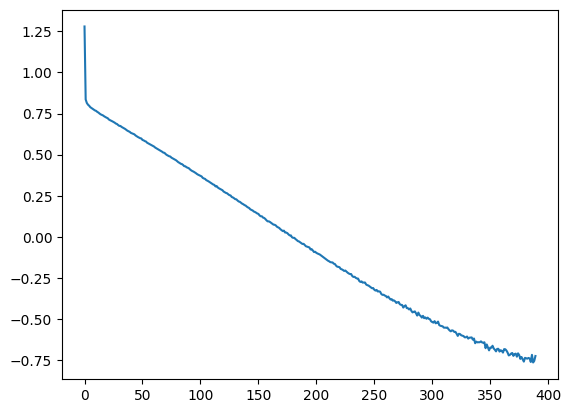

In [77]:
plt.plot(loss_vals)

In [78]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [79]:
%%script true
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])
means = means[1:]
print('Test MAE: {}'.format(torch.mean(torch.abs(means - y_test.cpu()))))
print('Test RMSE: {}'.format(torch.sqrt(torch.mean((means - y_test.cpu())**2))))

In [80]:
preds = likelihood(model(X_test))
print("MAE: ", mean_absolute_error(preds,y_test))
print("RMSE: ", torch.sqrt(mean_squared_error(preds,y_test)))
print("avg NLPD: ", mean_standardized_log_loss(preds,y_test))

MAE:  tensor(0.0764, grad_fn=<MeanBackward1>)
RMSE:  tensor(0.0991, grad_fn=<SqrtBackward0>)
avg NLPD:  tensor(-0.7769, grad_fn=<MeanBackward1>)


In [81]:
# y_std*mean_absolute_error(preds,y_test)

## without ng

In [82]:
class SVGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(SVGP, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
inducing_points = X_train[:500]    
model = SVGP(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_dataset = TensorDataset(X_train,y_train)
train_loader = DataLoader(train_dataset,batch_size=1024,shuffle=True)

model.train()
likelihood.train()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0)) # notice the num_data argument

optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()),lr = 0.01)

loss_vals = []
num_epochs = 30
epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
    
    for x_batch, y_batch in minibatch_iter:
        ### Perform NGD step to optimize variational parameters
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/13 [00:00<?, ?it/s]

In [83]:
preds = likelihood(model(X_test))
print("MAE: ", mean_absolute_error(preds,y_test))
print("RMSE: ", torch.sqrt(mean_squared_error(preds,y_test)))
print("avg NLPD: ", mean_standardized_log_loss(preds,y_test))

MAE:  tensor(0.0754, grad_fn=<MeanBackward1>)
RMSE:  tensor(0.0986, grad_fn=<SqrtBackward0>)
avg NLPD:  tensor(-0.7938, grad_fn=<MeanBackward1>)


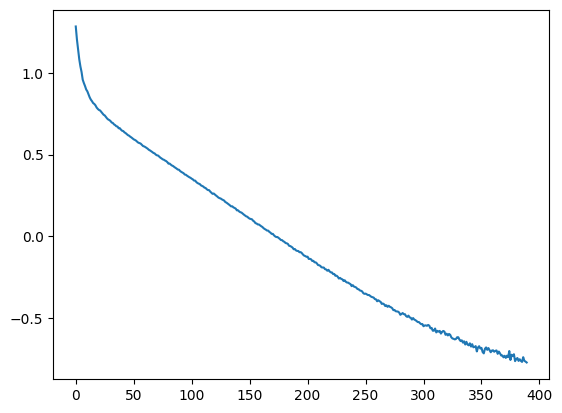

In [84]:
plt.plot(loss_vals)

## Pogpe

In [85]:
import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from optax import adam, chain, clip

from numpyro import distributions as dist

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy import linalg


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_x64()

In [86]:
X_train,y_train= X_train.numpy(),y_train.numpy()
X_test,y_test = X_test.numpy(),y_test.numpy()

In [87]:
def og_pogpe(X, M=None, S = 50, Y=None, y_test=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, DIM)) # S is the number of spectral freqs

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        # noise_mu_ex = numpyro.sample("kernel_noise_exp_mean", dist.InverseGamma(5.0, 5.0))
        std_ex_un = numpyro.sample('std_ex_un', dist.InverseGamma(5.0, 5.0))
        std_ex = numpyro.deterministic('std_ex', jnp.tile(jnp.reshape(std_ex_un, (-1, 1)), N))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 10.0))

            
    assert lengthscale_ex.shape == (M,DIM)
    assert Omega_fixed.shape == (S,DIM)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))      
    matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))                                                                                                                      
    Omega_ex = vdivide( Omega_fixed, lengthscale_ex)     # shape = (M,S,DIM)
    ########
    assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_ex = 1/jnp.sqrt(S)*Phi_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_ex.shape == (M, N, 2*S)
    assert std_ex.shape == (M,N)
    assert theta_mu_ex.shape == (M,2*S)

    # theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex+ noise_mu_ex),2*S) * theta_mu_ex
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_ex,theta_mu_ex) )                 # shape = (M,Ndata)
    assert mu_ex.shape == (M,N)



    #########################
    # RF-GP for log weights #
    #########################
    with numpyro.plate("M", M, dim=-2):
        # set uninformative log-normal priors on our three kernel hyperparameters
        var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
        # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

        with numpyro.plate('2S', 2*S):
            theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with numpyro.plate("DIM", DIM):
            lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 10.0))

    assert lengthscale_logw.shape == (M,DIM)

    # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    assert theta_logw.shape == (M,2*S)


    Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    # w = numpyro.deterministic("w", jnp.ones((M,N)))  # All weights are one (not trained)
    # w  = w.T
    tau_ex = 1. / std_ex

    assert w.shape == (M,N)
    tau_fused = numpyro.deterministic(
        "tau_fused", 
        # jnp.einsum("nm,mn->m", tau_ex, w),
        jnp.sum(tau_ex*w,axis=0).squeeze()
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", 
        # jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused,
        jnp.sum(tau_ex*mu_ex*w,axis=0).squeeze()/tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    Y = jnp.squeeze(Y)
    numpyro.sample(
        "y_val",
        dist.Normal(loc=mu_fused, 
                    scale=std_fused,
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [88]:
def train_and_predict_joint(model, num_experts, num_spectral_freqs, data_dict, 
                            guide_svi = None,
                            training_iter = 500, lr = 0.1,
                            **kwargs):
    guide = guide_svi or AutoDelta(model, 
                    init_loc_fn = numpyro.infer.initialization.init_to_median,
                    # init_loc_fn = numpyro.infer.initialization.init_to_uniform,
                    # init_loc_fn = numpyro.infer.init_to_sample,
                    )
    svi= SVI(model,
            guide,
            # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
            # optim=chain(clip(10.0), adam(0.005)),
            optim = numpyro.optim.Adam(lr),
            loss=Trace_ELBO(num_particles=1),   # default is 1
        )


    res = svi.run(
        jax.random.PRNGKey(30),
        training_iter,  
        X=data_dict["X_train"],
        Y=data_dict["y_train"],
        M=num_experts,
        S=num_spectral_freqs,
        **kwargs,
    )

    params = res.params

    predictive = Predictive(guide, params=params, num_samples=100)
    posterior_samples = predictive(random.PRNGKey(3),
                                   X=data_dict["X_train"], 
                                   Y=data_dict["y_train"], 
                                   M=num_experts,
                                   S=num_spectral_freqs,
                                    y_test=data_dict["y_train"],
                                    **kwargs,)  # these are samples from the guide! See https://github.com/pyro-ppl/numpyro/issues/1309
    
    '''
    BEST option: (we bypass sampling posterior_samples from the guide)
    dist_posterior_predictive = Predictive(model=model,guide=guide, params=params, num_samples=100)
    '''
    dist_posterior_predictive = Predictive(model,posterior_samples)
    samples_tr = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                        X=data_dict["X_train"], 
                                        Y=data_dict["y_train"], 
                                        M=num_experts,
                                        S=num_spectral_freqs,
                                        y_test=data_dict["y_train"],
                                        **kwargs,
                                        )

    ymu_tr = samples_tr["mean_fused"].mean(0)
    ys_tr = samples_tr["std_fused"].mean(0)
    w_tr = samples_tr["w"].mean(0)

    nlpd_train = - jnp.mean(
        jax.nn.logsumexp(samples_tr["lpd_point"], axis=0) - jnp.log(samples_tr["lpd_point"].shape[0])
    )
    rmse_train = np.sqrt(np.mean((ymu_tr.squeeze()-data_dict["y_train"].squeeze())**2))

    # TEST DATA
    samples_tst = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                        X=data_dict["X_test"], 
                                        Y=data_dict["y_test"], 
                                        M=num_experts,
                                        S=num_spectral_freqs,
                                        y_test=data_dict["y_test"],
                                        **kwargs,
                                        )

    ymu_tst = samples_tst["mean_fused"].mean(0)
    ys_tst = samples_tst["std_fused"].mean(0)
    w_tst = samples_tst["w"].mean(0)

    nlpd_test = - jnp.mean(
        jax.nn.logsumexp(samples_tst["lpd_point"], axis=0) - jnp.log(samples_tst["lpd_point"].shape[0])
    )
    rmse_test = np.sqrt(np.mean((ymu_tst.squeeze()-data_dict["y_test"].squeeze())**2))


    return nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr, res

In [89]:
num_experts = 4
num_spectral_freqs = 100
model = og_pogpe

# map estimates
nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
    model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
    data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
    training_iter=1000, lr= 0.1,
)


print("nlpd train: ", nlpd_train)
print("nlpd test: ", nlpd_test)

print("rmse train: ", rmse_train)
print("rmse test: ", rmse_test)

print("mae train: ", np.mean(np.abs(samples_tr["mean_fused"].mean(0).squeeze() - y_train.squeeze())))
print("mae test: ", np.mean(np.abs(samples_tst["mean_fused"].mean(0).squeeze() - y_test.squeeze())))

100%|██████████| 1000/1000 [01:23<00:00, 11.94it/s, init loss: 18315.0774, avg. loss [951-1000]: -12008.0613]


nlpd train:  -1.0873478592353973
nlpd test:  -1.0813156621801923
rmse train:  0.08727766753365232
rmse test:  0.08841893719817635
mae train:  0.06657753697381684
mae test:  0.06704402366928036


(50.0, 100.0)

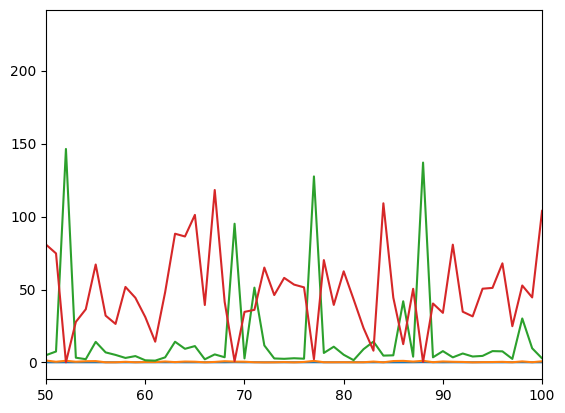

In [90]:
for i in range(num_experts):
    plt.plot(samples_tst["w"].mean(0)[i,:])
plt.xlim(50,100)    

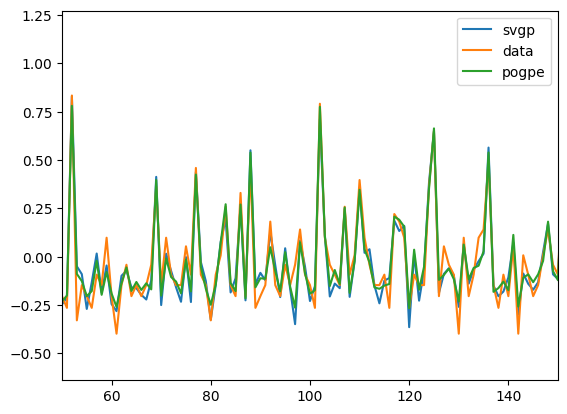

In [92]:
plt.plot(preds.mean.detach().numpy(),label = "svgp")
plt.plot(y_test, label = "data")
plt.plot(samples_tst["mean_fused"].mean(0),label = "pogpe")
plt.xlim((50,150))
plt.legend()